In [22]:
from pathlib import Path
from typing import List, Tuple

import matplotlib.pyplot as plt

In [23]:
def parse_training_loss(log_path: Path) -> Tuple[List[float], List[int]]:
    steps_list = []
    loss_list = []
    with open(log_path, 'r') as log_file:
        for line in log_file:
            if 'Loss' not in line:
                continue
            line_split = line.split(',')
            if len(line_split) != 4:
                continue

            step = line_split[0]
            epoch, iteration = step.split(' Iter: ')
            epoch = int(epoch.replace('Epoch: ', ''))
            iteration, iteration_max = iteration.split('/')
            iteration = int(iteration)
            iteration_max = int(iteration_max)
            loss = line_split[-2].replace('Loss: ', '')
            loss = float(loss)
            loss_list.append(loss)
            steps_list.append(epoch * iteration_max + iteration)

    return loss_list, steps_list


def get_log_identifier(log_path: Path) -> int:
    filename = log_path.stem
    identifier = filename.split('-')[-1]
    return int(identifier)


def get_training_loss_and_steps(path_to_logs: Path) -> Tuple[List[float], List[int]]:
    loss_all = []
    steps_all = []
    for log_file in sorted(path_to_logs.glob('*-log-epoch-*.log'), key=get_log_identifier):
        loss, steps = parse_training_loss(log_file)
        loss_all += loss
        steps_all += steps

    return loss_all, steps_all

In [49]:
def plot_model_loss(plot_name: str, train_loss: List[float], train_steps: List[int]) -> None:
    plt.figure(figsize=(15, 7))
    plt.plot(train_steps, train_loss, lw=3, c='royalblue')
    plt.xlabel('Iterations')
    plt.ylabel('Loss')
    plt.grid()
    # plt.savefig(f'images/results/{plot_name}.png', dpi=300)
    plt.show()


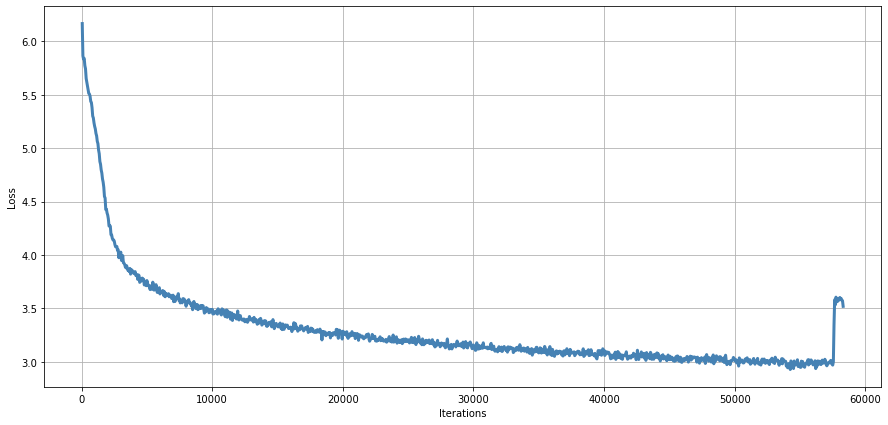

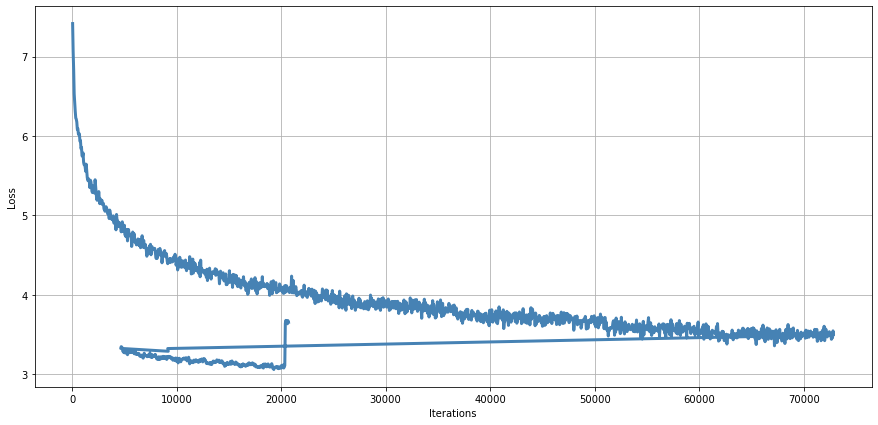

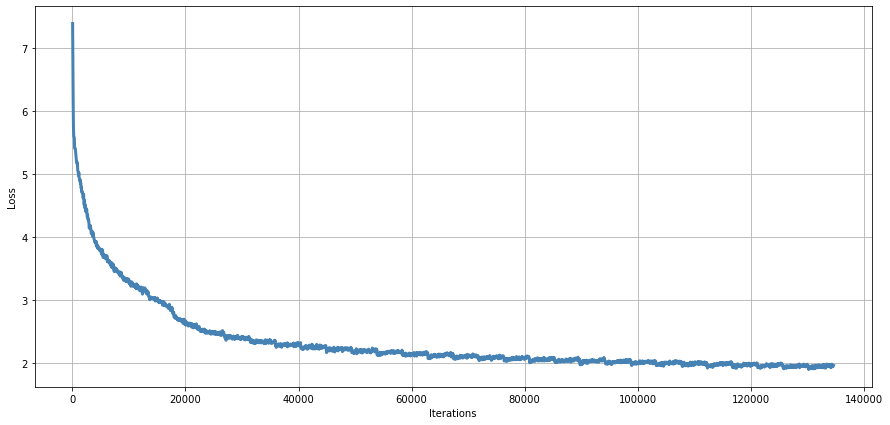

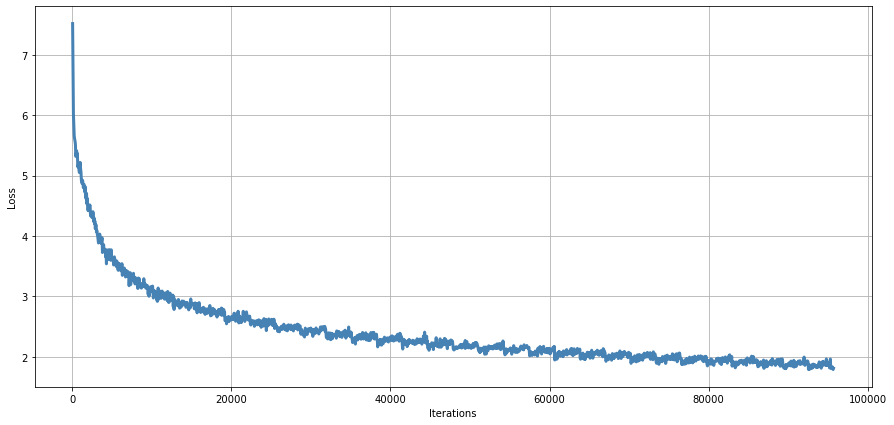

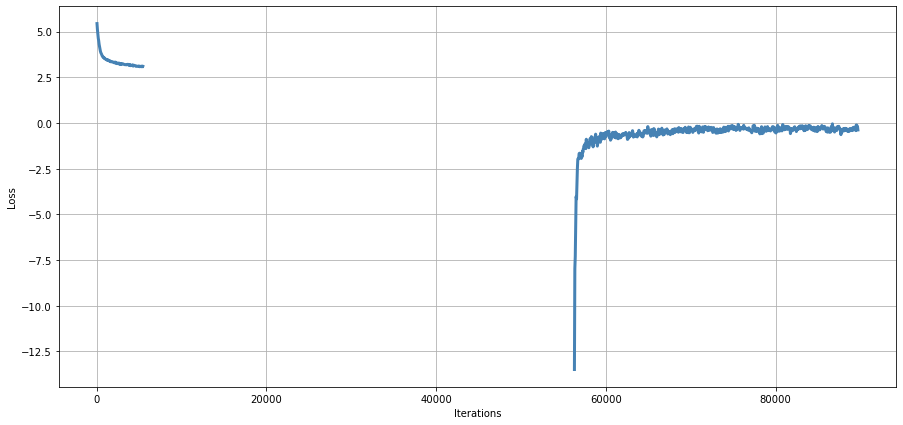

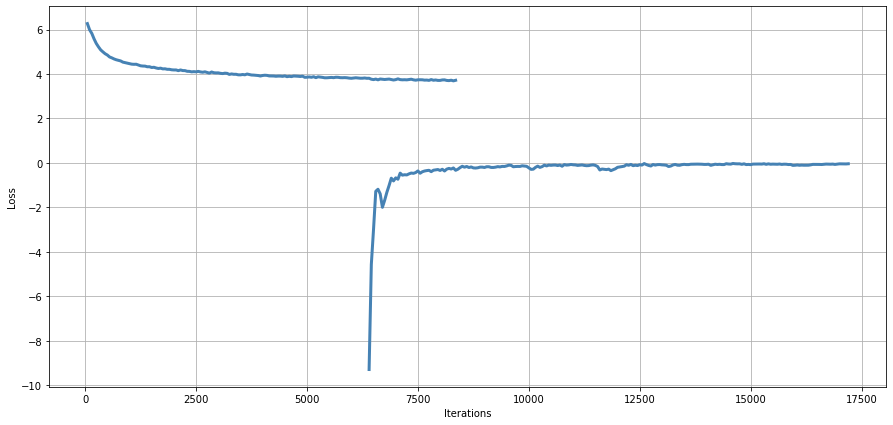

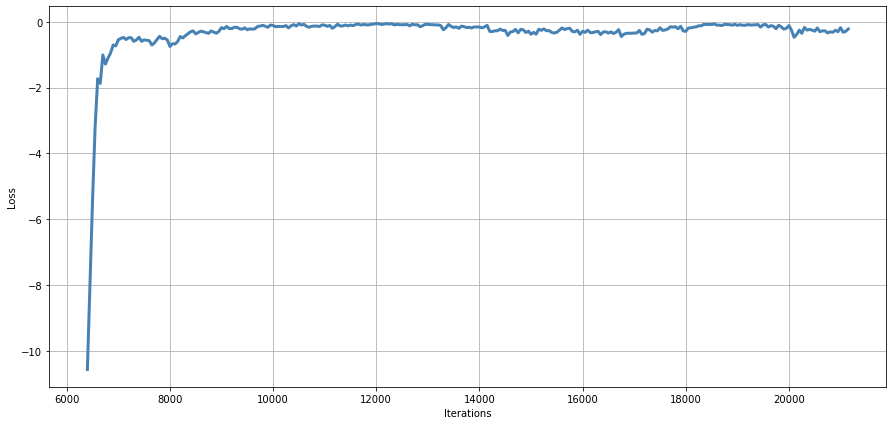

In [48]:
paths = [
    '../data/saved2/logs/pointer_generator',
    '../data/saved2/logs/pointer_generator-xsum',
    '../data/saved2/logs/transformer',
    '../data/saved2/logs/transformer-xsum',
    '../data/saved2/logs/reinforcement_learning',
    '../data/saved2/logs/reinforcement_learning-xsum',
    '../data/saved2/logs/reinforcement_learning-xsum-mixed',
]

for path in paths:
    model_name = path.split('/')[-1]
    training_loss, training_steps = get_training_loss_and_steps(Path(path))
    plot_model_loss(model_name, training_loss, training_steps)

..\data\saved2\logs\pointer_generator\pointer_generator-log-epoch-0.log
..\data\saved2\logs\pointer_generator\pointer_generator-log-epoch-1.log
..\data\saved2\logs\pointer_generator\pointer_generator-log-epoch-10.log
..\data\saved2\logs\pointer_generator\pointer_generator-log-epoch-11.log
..\data\saved2\logs\pointer_generator\pointer_generator-log-epoch-12.log
..\data\saved2\logs\pointer_generator\pointer_generator-log-epoch-2.log
..\data\saved2\logs\pointer_generator\pointer_generator-log-epoch-3.log
..\data\saved2\logs\pointer_generator\pointer_generator-log-epoch-4.log
..\data\saved2\logs\pointer_generator\pointer_generator-log-epoch-5.log
..\data\saved2\logs\pointer_generator\pointer_generator-log-epoch-6.log
..\data\saved2\logs\pointer_generator\pointer_generator-log-epoch-7.log
..\data\saved2\logs\pointer_generator\pointer_generator-log-epoch-8.log
..\data\saved2\logs\pointer_generator\pointer_generator-log-epoch-9.log
